[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO11 Object Detection on a Custom Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Jan 20 20:04:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.05              Driver Version: 560.35.05      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060        Off |   00000000:01:00.0  On |                  N/A |
| N/A   58C    P0             23W /   80W |     757MiB /   6144MiB |     24%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!rm -rf {HOME}/datasets
!rm -rf {HOME}/runs/detect/predict*
!rm -rf {HOME}/runs/detect/train*
!rm -rf {HOME}/runs/detect/val*


**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/home/toor/dev/tfoo


## Install YOLO11 via Ultralytics

In [3]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.9.21 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 2060, 5708MiB)
Setup complete ✅ (16 CPUs, 15.0 GB RAM, 53.0/72.7 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [ ]:
!rm -rf {HOME}/runs/detect/predict*

In [4]:
import os
import glob

def run_yolo_and_store_results(source_url='https://static.themarthablog.com/2021/08/PXL_20210809_185425726-scaled.jpeg'):
  """Runs YOLO prediction and stores the results folder and file name in global variables.

  Args:
    source_url: The URL of the image to predict on.
  """

  # Run YOLO prediction
  !yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source={source_url} save=True

  # Find latest prediction folder
  latest_folder = max(glob.glob(os.path.join(HOME, 'runs', 'detect', 'predict*')), key=os.path.getmtime)

  # Store folder path in global variable
  globals()['PREDICTED_FOLDER'] = latest_folder

  # Find the latest file in the folder and get its name
  latest_file = max(glob.glob(os.path.join(PREDICTED_FOLDER, '*')), key=os.path.getmtime)
  predicted_file_name = os.path.basename(latest_file)

  # Store file name in global variable
  globals()['predicted_file_name'] = predicted_file_name

# Call the function to run YOLO and store results
run_yolo_and_store_results()

100%|██████████████████████████████████████| 5.35M/5.35M [00:00<00:00, 12.2MB/s]
Ultralytics 8.3.40 🚀 Python-3.9.21 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 2060, 5708MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100%|██████████████████████████████████████| 3.59M/3.59M [00:00<00:00, 20.7MB/s]
image 1/1 /home/toor/dev/tfoo/PXL_20210809_185425726-scaled.jpeg: 640x640 7 birds, 8.9ms
Speed: 4.1ms preprocess, 8.9ms inference, 127.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

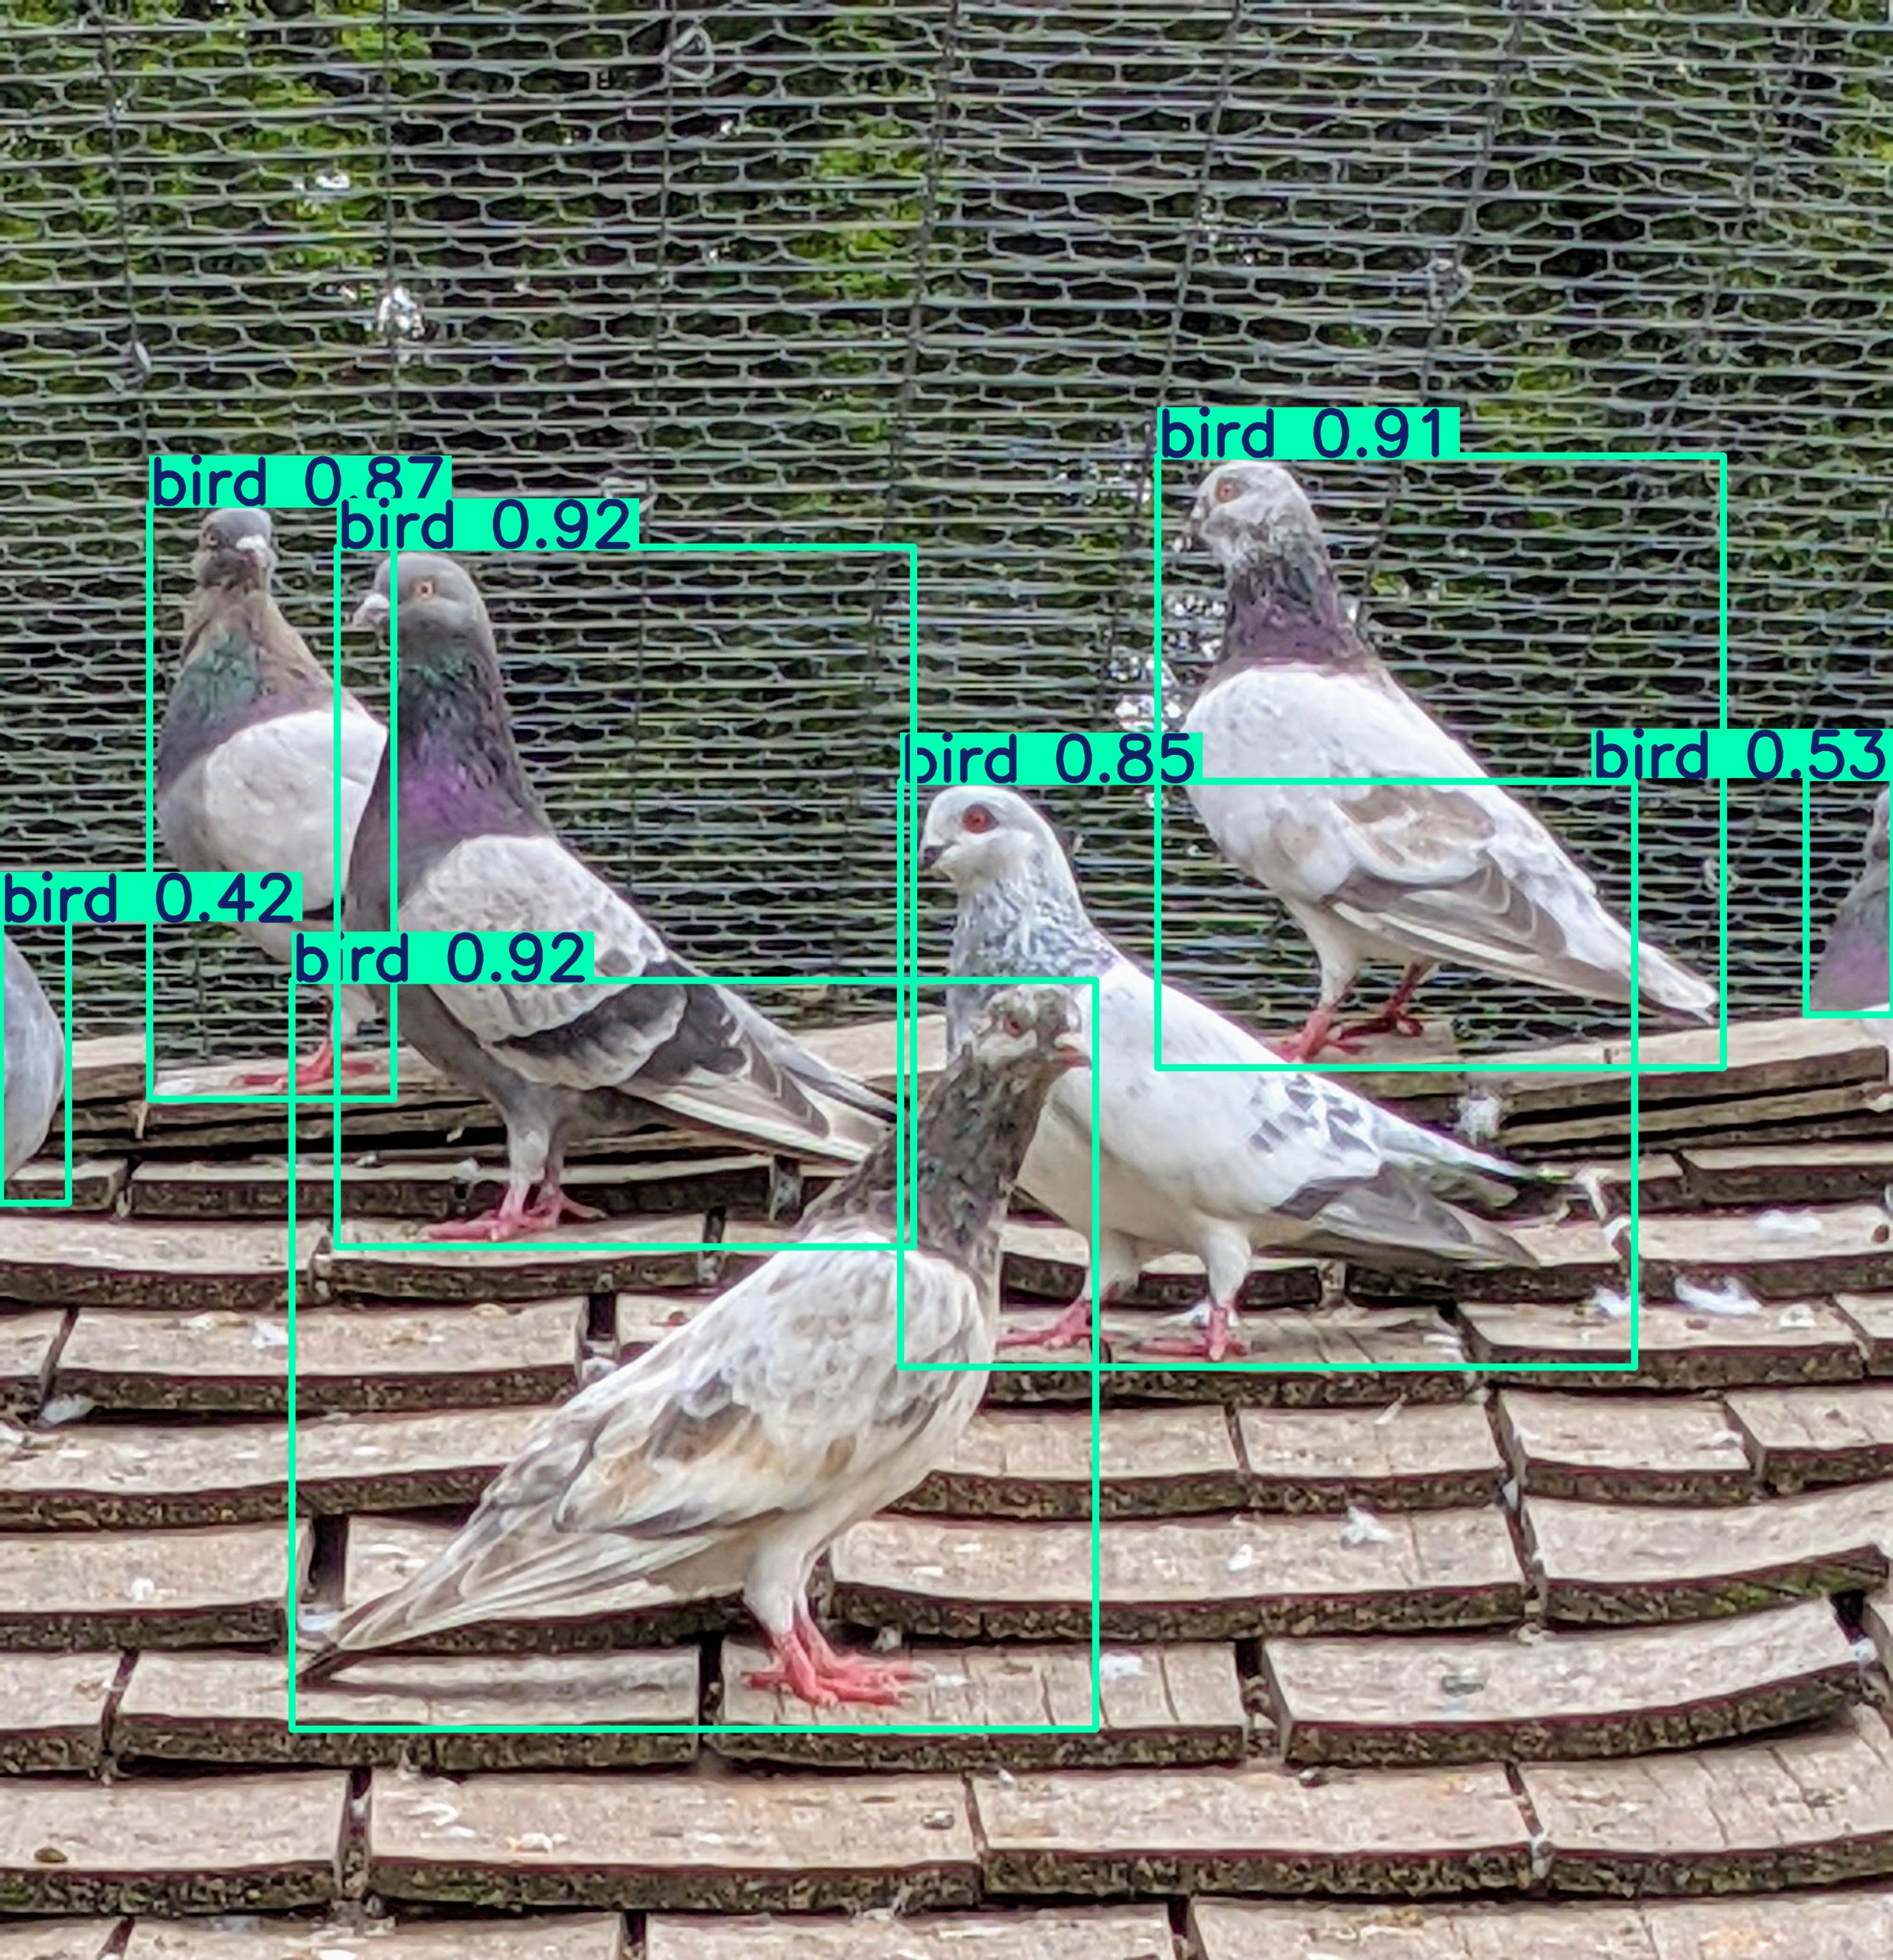

In [5]:
from IPython.display import Image as IPyImage
import os

IPyImage(filename=os.path.join(PREDICTED_FOLDER, predicted_file_name), width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [6]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://static.themarthablog.com/2021/08/PXL_20210809_185425726-scaled.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]


0: 640x640 7 birds, 6.5ms
Speed: 5.0ms preprocess, 6.5ms inference, 110.4ms postprocess per image at shape (1, 3, 640, 640)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [7]:
result.boxes.xyxy

tensor([[4.4050e+02, 7.1452e+02, 1.1936e+03, 1.6281e+03],
        [3.8150e+02, 1.2800e+03, 1.4317e+03, 2.2582e+03],
        [1.5120e+03, 5.9529e+02, 2.2511e+03, 1.3948e+03],
        [1.9514e+02, 6.5900e+02, 5.1457e+02, 1.4354e+03],
        [1.1769e+03, 1.0209e+03, 2.1354e+03, 1.7858e+03],
        [2.3591e+03, 1.0159e+03, 2.4730e+03, 1.3257e+03],
        [9.9309e-01, 1.2022e+03, 8.9583e+01, 1.5717e+03]], device='cuda:0')

In [8]:
result.boxes.conf

tensor([0.9233, 0.9168, 0.9113, 0.8687, 0.8519, 0.5305, 0.4172], device='cuda:0')

In [9]:
result.boxes.cls

tensor([14., 14., 14., 14., 14., 14., 14.], device='cuda:0')

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [10]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

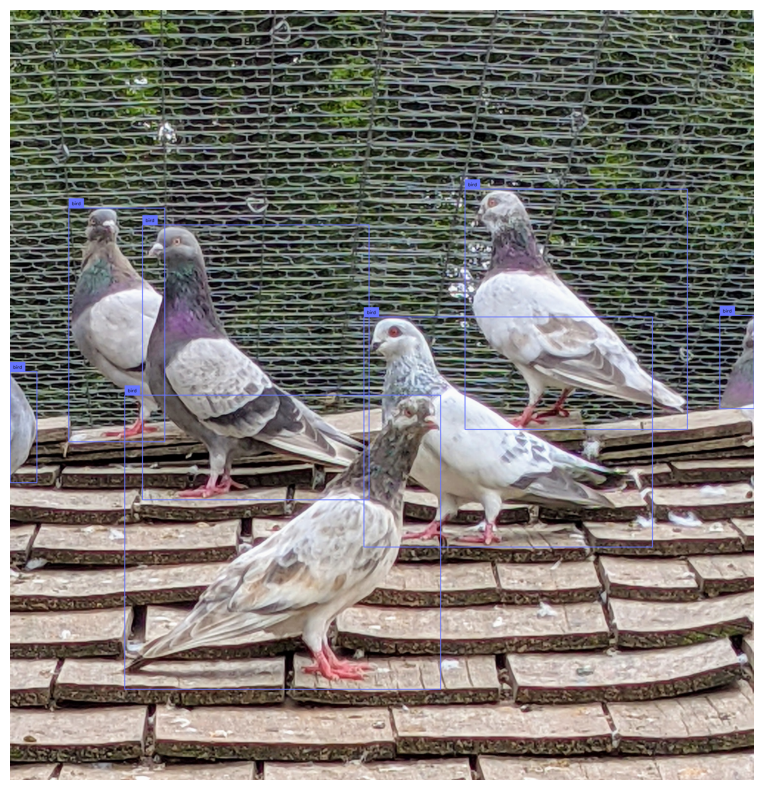

In [11]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [13]:
!pip install pickleshare

  Using cached pickleshare-0.7.5-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached pickleshare-0.7.5-py2.py3-none-any.whl (6.9 kB)


In [15]:
!rm -rf {HOME}/datasets
!mkdir {HOME}/datasets
%cd {HOME}/datasets

#from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = "39VO5sX8x0esxMZwPTsU"
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

workspace = rf.workspace("myplayspace")
project = workspace.project("pigeon-hunter")
version = project.version(2)
dataset = version.download("yolov11")

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
/home/toor/dev/tfoo/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pigeon-Hunter-2 in yolov11:: 100%|█| 9366/9366


## Custom Training

In [16]:
print(dataset.location)  # verify the dataset path

/home/toor/dev/tfoo/datasets/Pigeon-Hunter-2


In [17]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/home/toor/dev/tfoo
100%|██████████████████████████████████████| 18.4M/18.4M [00:00<00:00, 30.9MB/s]
New https://pypi.org/project/ultralytics/8.3.64 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.9.21 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 2060, 5708MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/home/toor/dev/tfoo/datasets/Pigeon-Hunter-2/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, s

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [18]:
!ls {HOME}/runs/detect/train/

args.yaml				  results.png
confusion_matrix_normalized.png		  train_batch0.jpg
confusion_matrix.png			  train_batch1.jpg
events.out.tfevents.1737396507.kk.5882.0  train_batch2.jpg
F1_curve.png				  val_batch0_labels.jpg
labels_correlogram.jpg			  val_batch0_pred.jpg
labels.jpg				  val_batch1_labels.jpg
P_curve.png				  val_batch1_pred.jpg
PR_curve.png				  val_batch2_labels.jpg
R_curve.png				  val_batch2_pred.jpg
results.csv				  weights


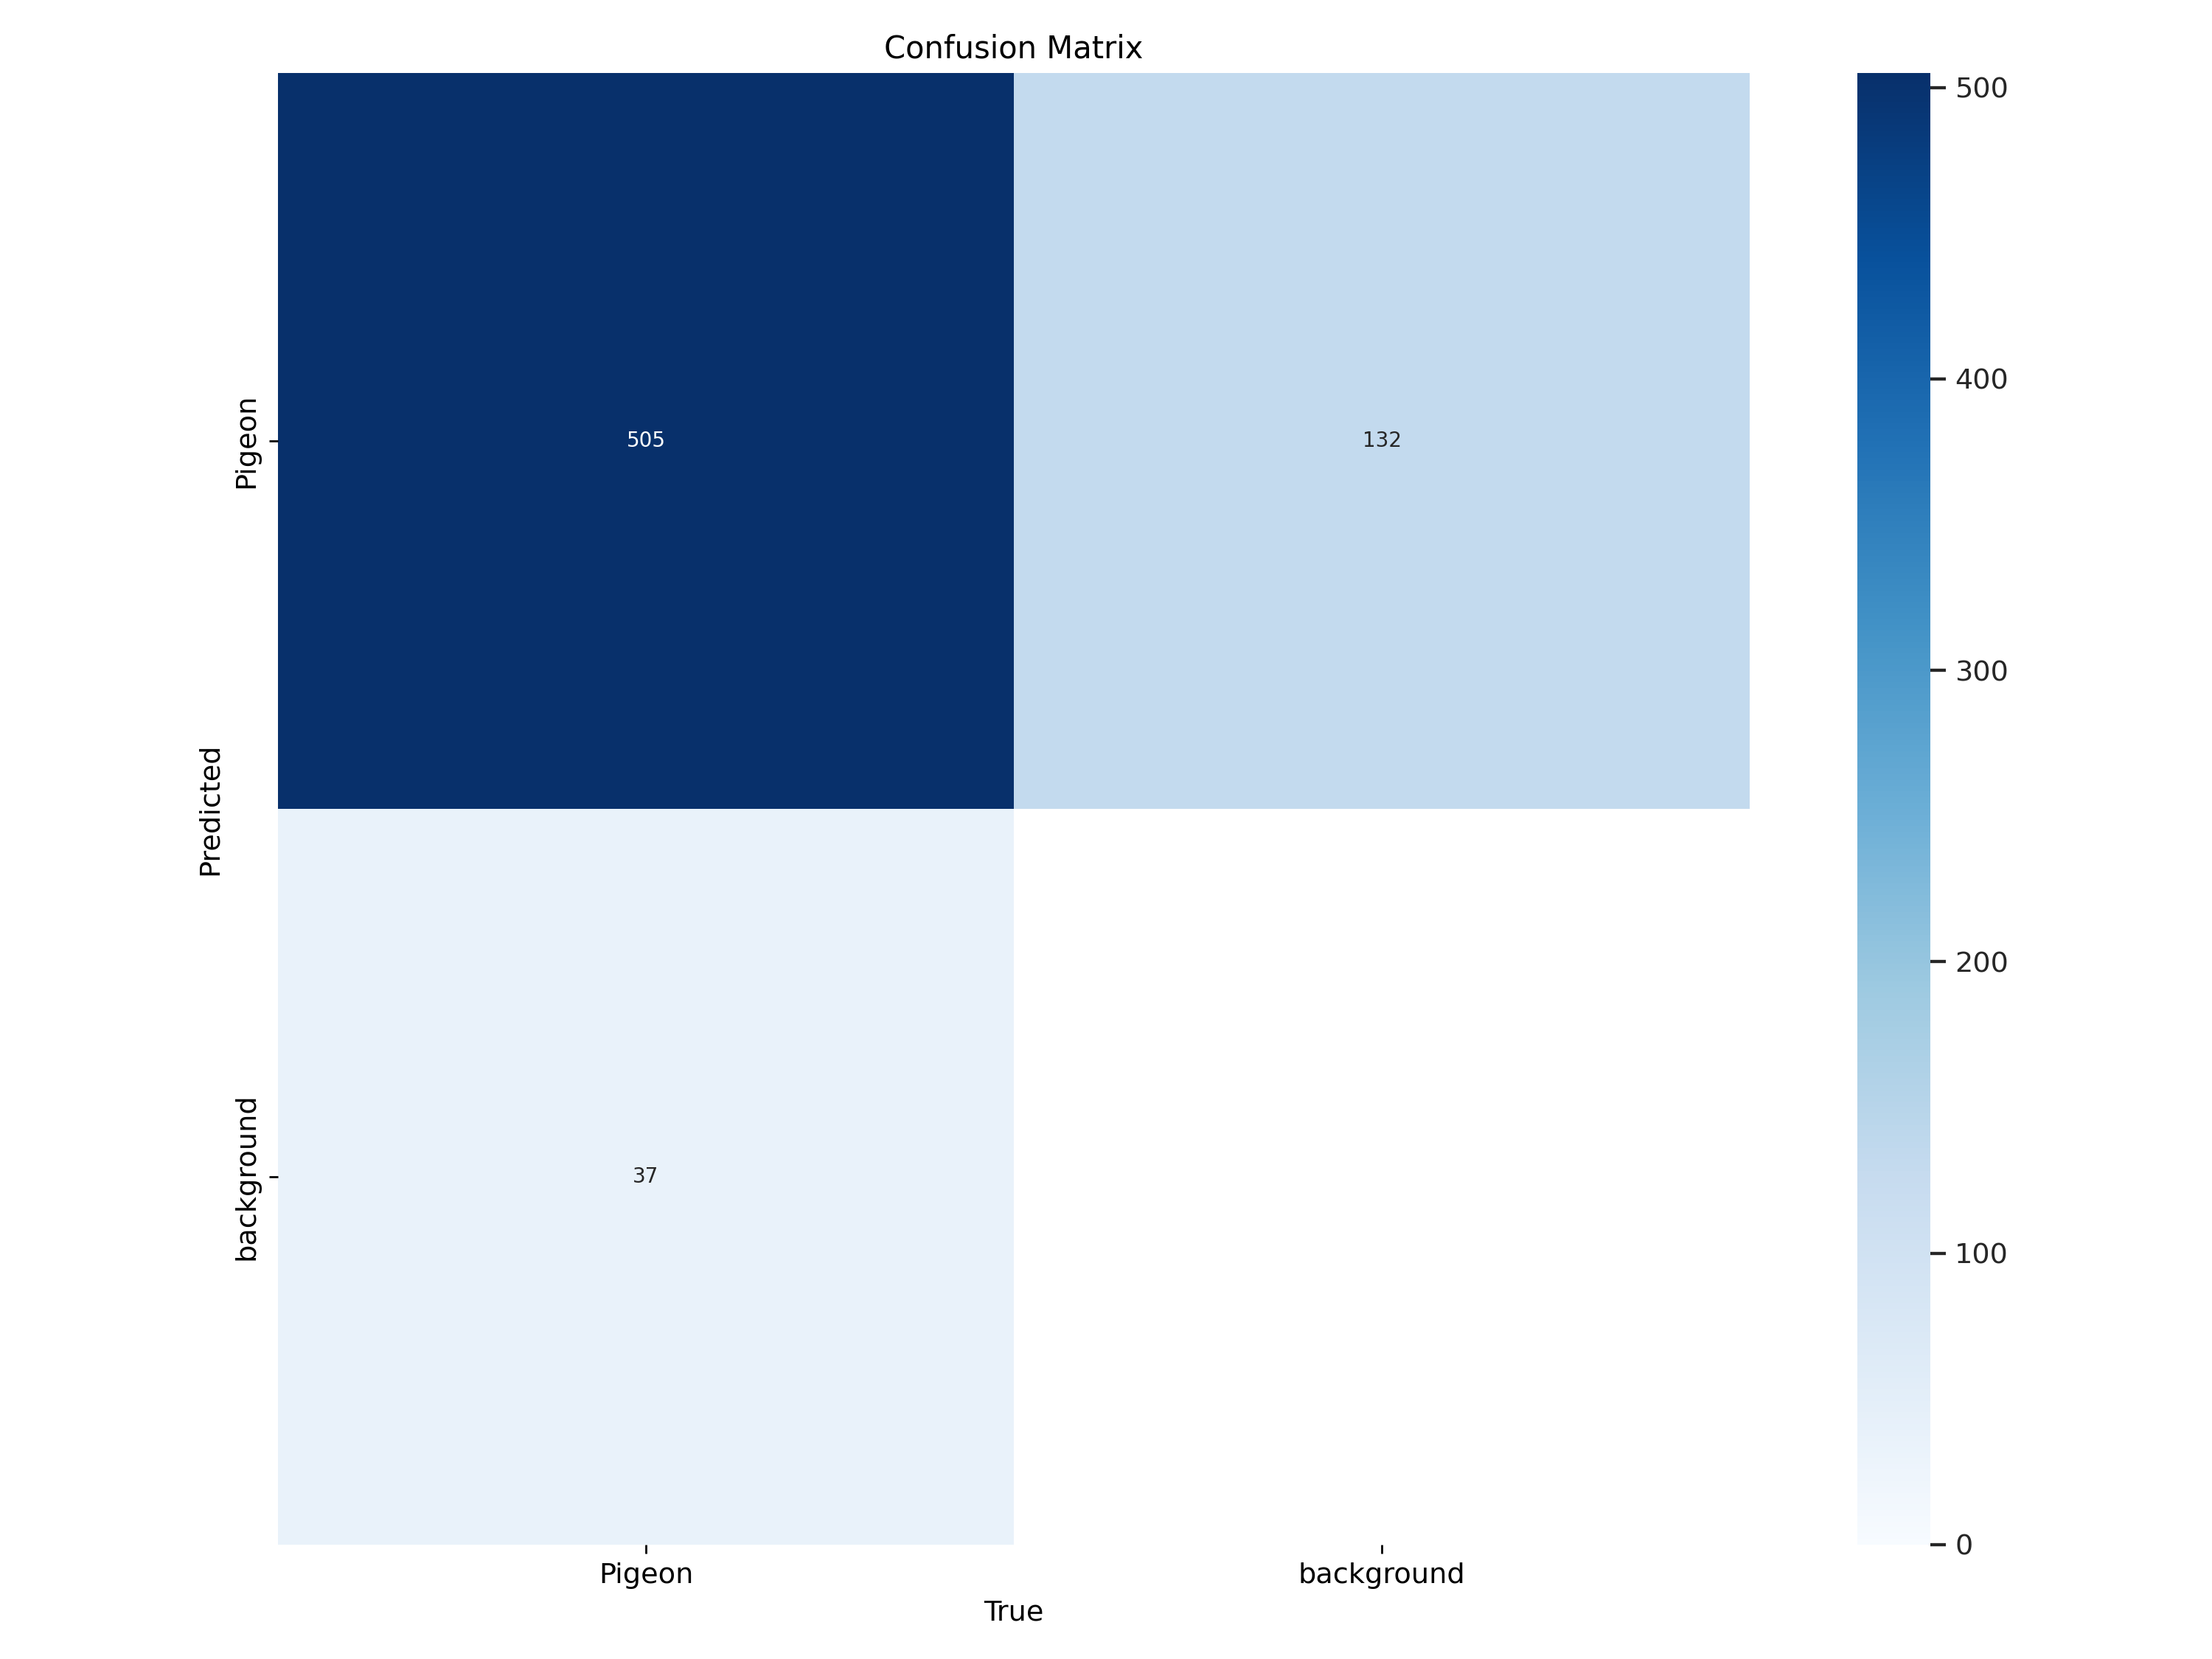

In [19]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

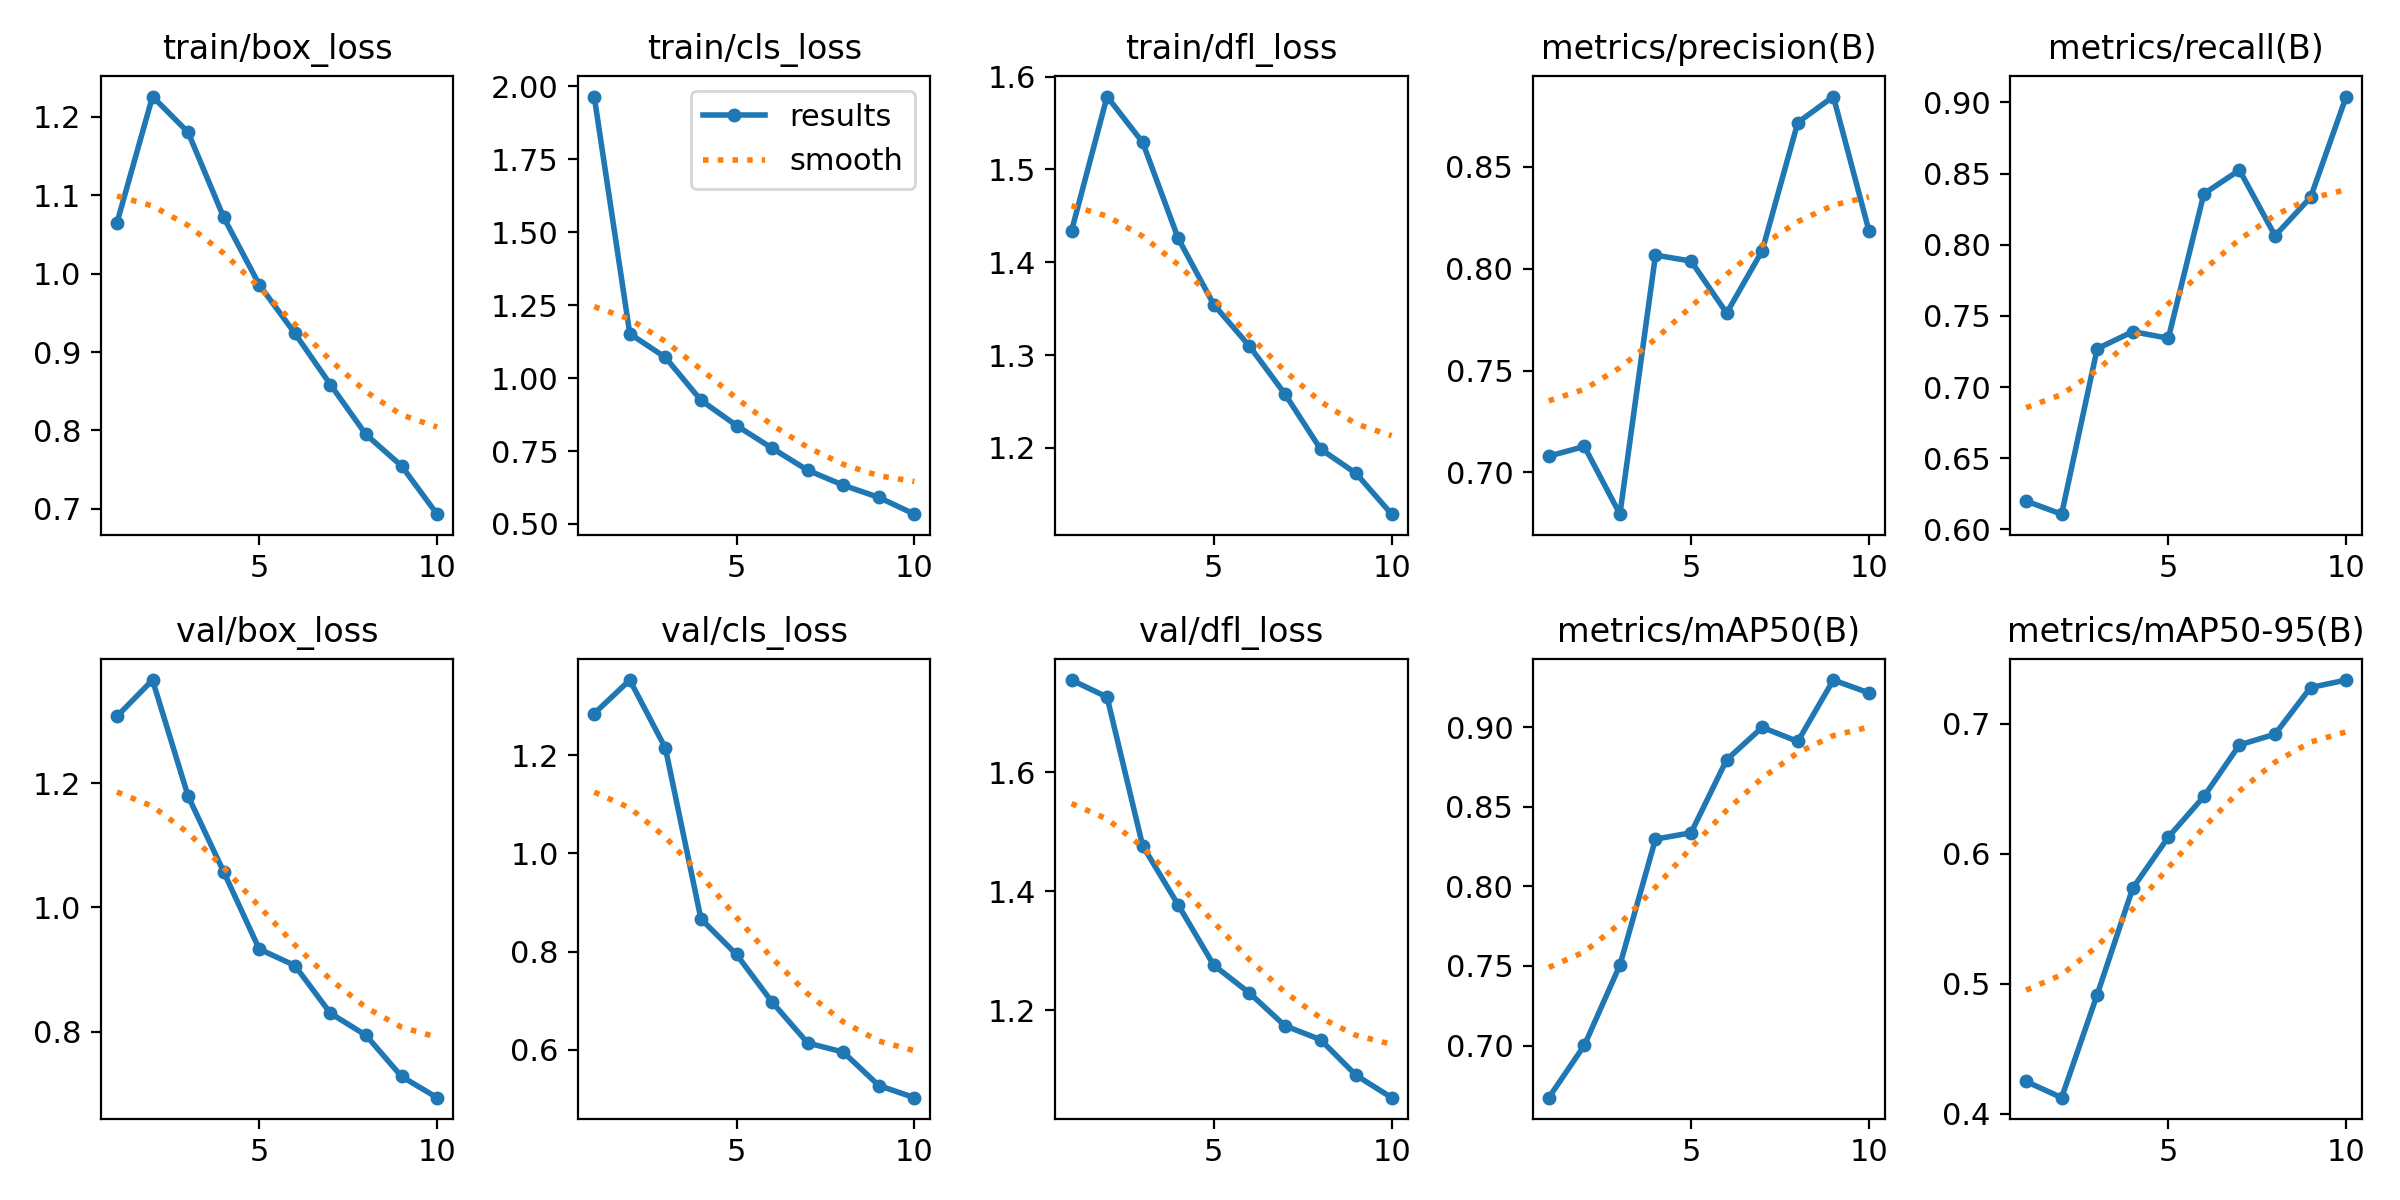

In [20]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

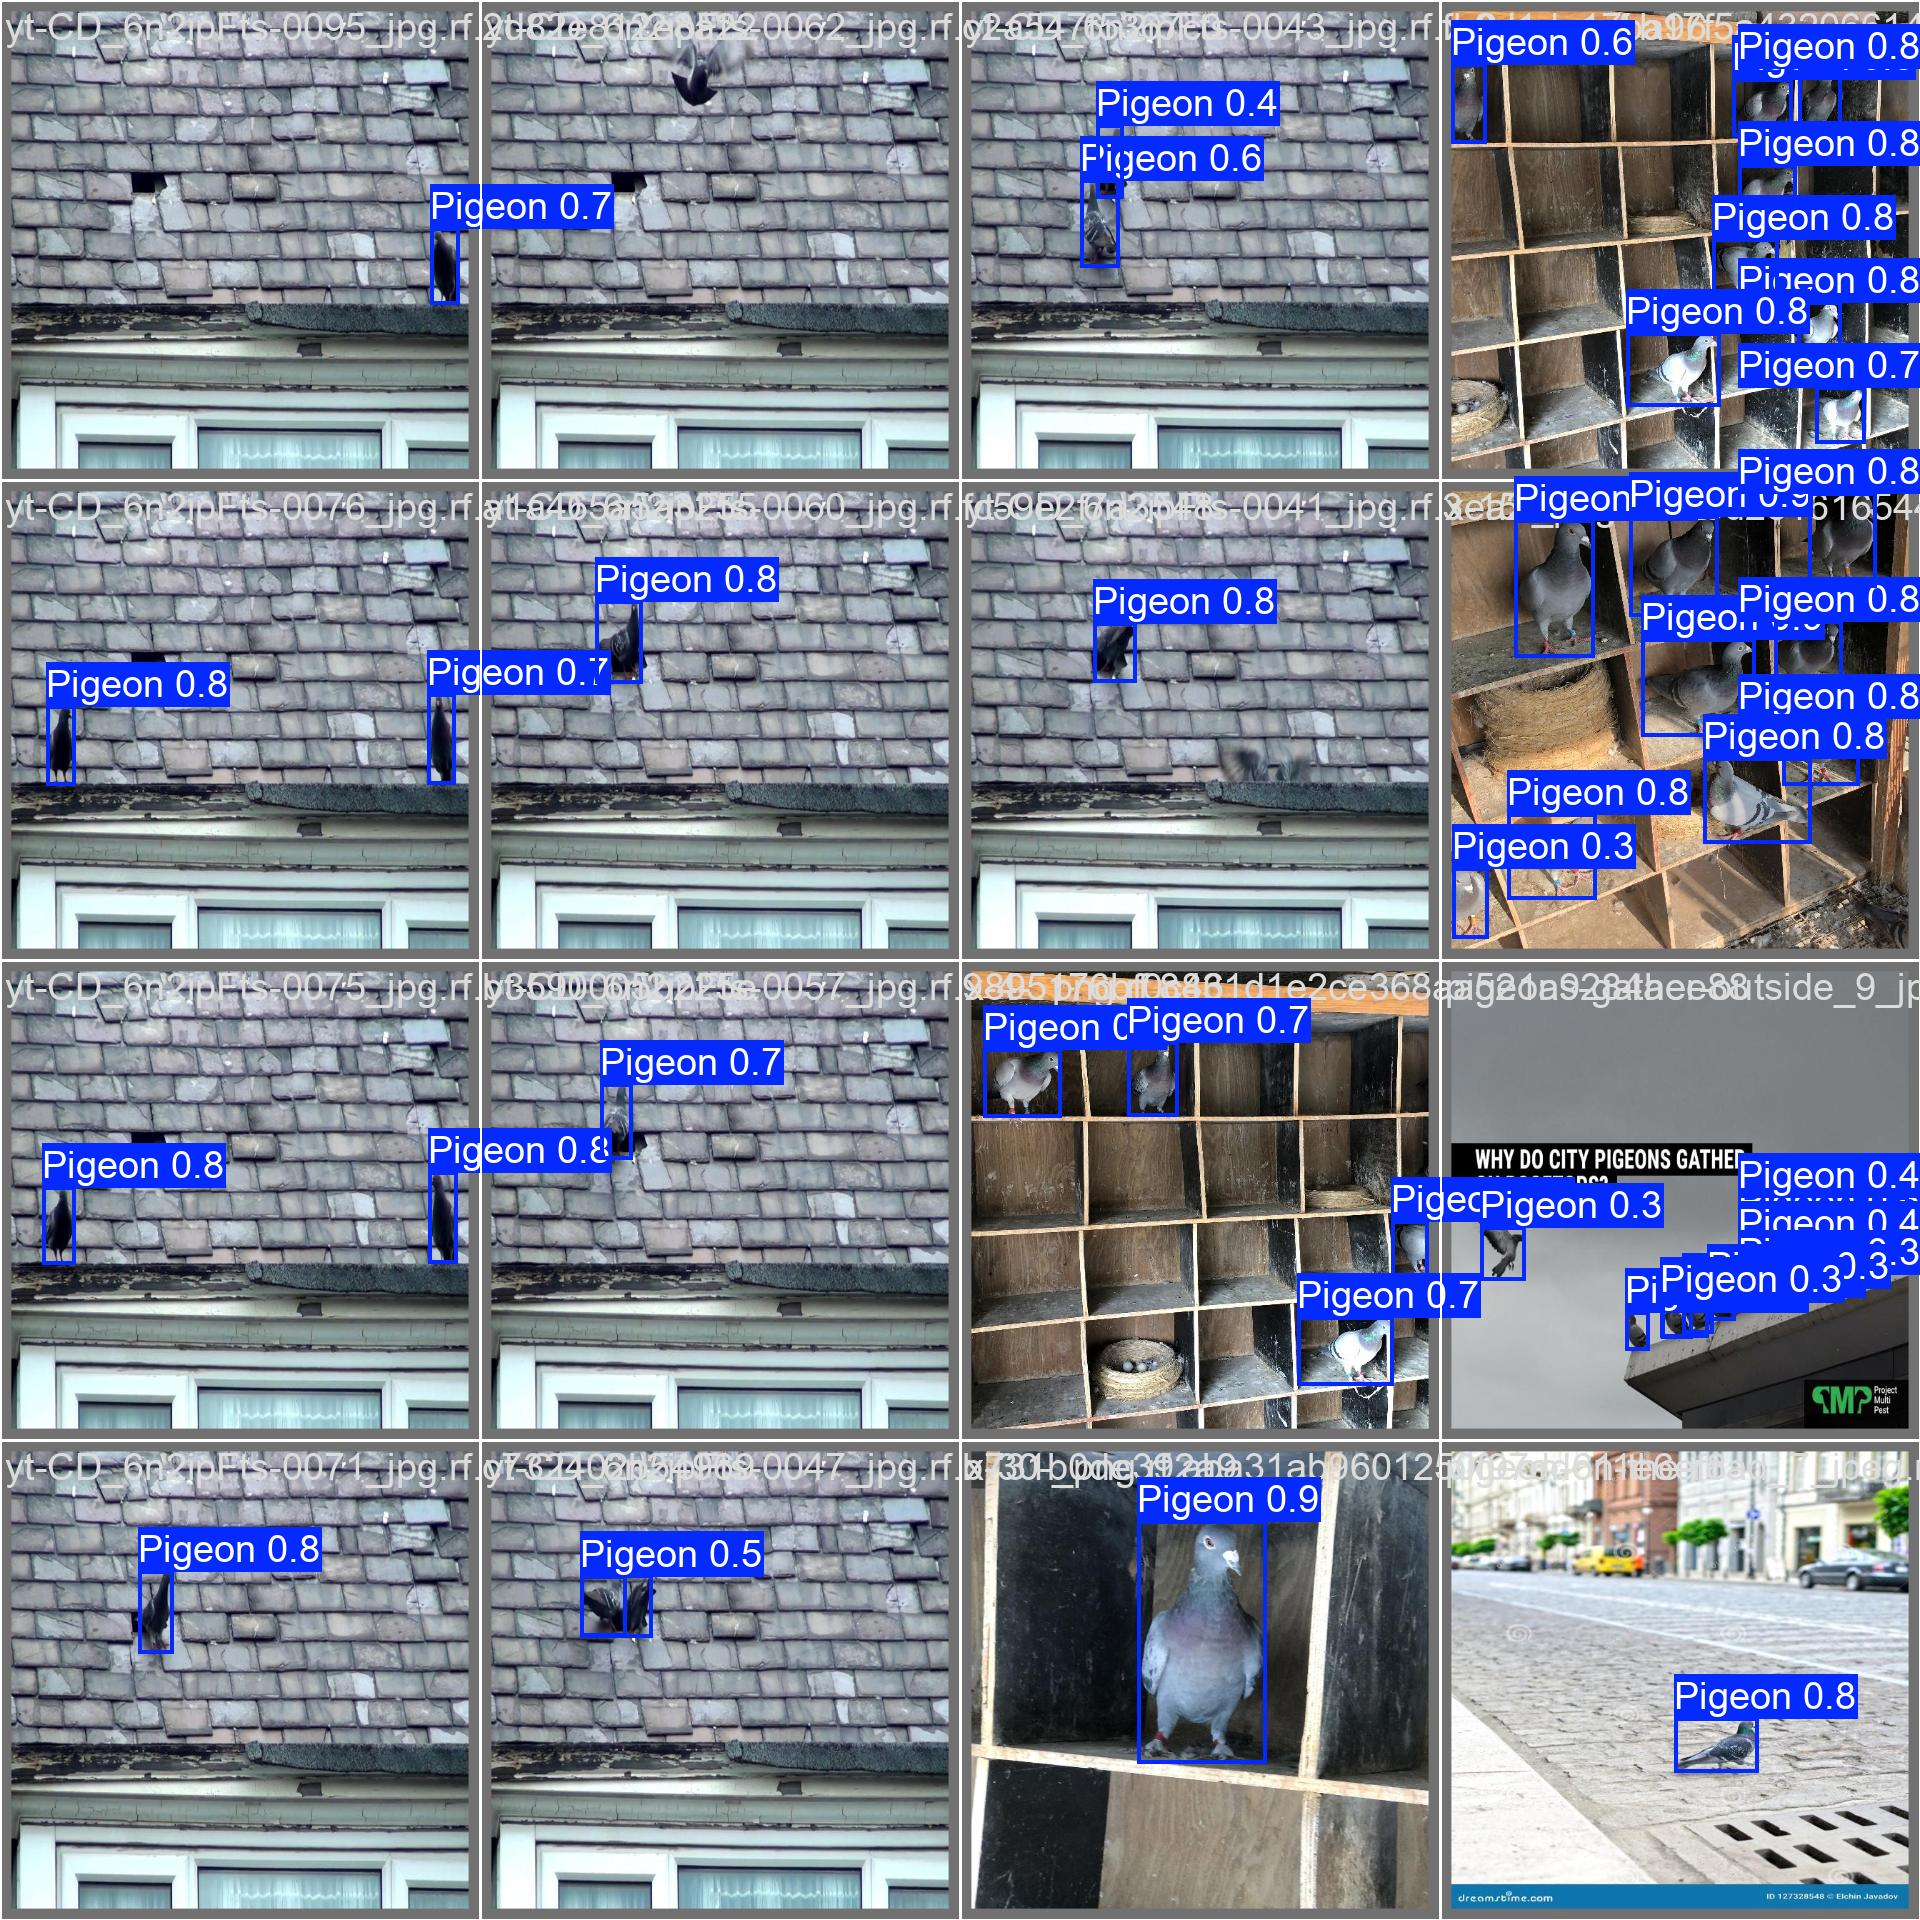

In [21]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [22]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.9.21 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 2060, 5708MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /home/toor/dev/tfoo/datasets/Pigeon-Hunter-2/valid/labels.cache...
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        276        542      0.819        0.9      0.921      0.733
Speed: 1.0ms preprocess, 10.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference with custom model

In [23]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.9.21 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 2060, 5708MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

image 1/515 /home/toor/dev/tfoo/datasets/Pigeon-Hunter-2/test/images/002_jpg.rf.4eb3a6d9252920faea67588a8531907e.jpg: 640x640 1 Pigeon, 14.7ms
image 2/515 /home/toor/dev/tfoo/datasets/Pigeon-Hunter-2/test/images/003_jpg.rf.6ade10cce458f47d3e9999d2e2df247f.jpg: 640x640 1 Pigeon, 14.3ms
image 3/515 /home/toor/dev/tfoo/datasets/Pigeon-Hunter-2/test/images/003_jpg.rf.b8074fa3e4b12e27a2fb527ec2c95137.jpg: 640x640 1 Pigeon, 14.7ms
image 4/515 /home/toor/dev/tfoo/datasets/Pigeon-Hunter-2/test/images/004_jpg.rf.55c1c5550279323fd8bb5e83792de77a.jpg: 640x640 1 Pigeon, 15.5ms
image 5/515 /home/toor/dev/tfoo/datasets/Pigeon-Hunter-2/test/images/004_jpg.rf.9a1cae665ae50fa4633201b782f6c8af.jpg: 640x640 1 Pigeon, 15.2ms
image 6/515 /home/toor/dev/tfoo/datasets/Pigeon-Hunter-2/test/images/009_jpg.rf.eb35d9bc25383d4382c1446a5

**NOTE:** Let's take a look at few results.

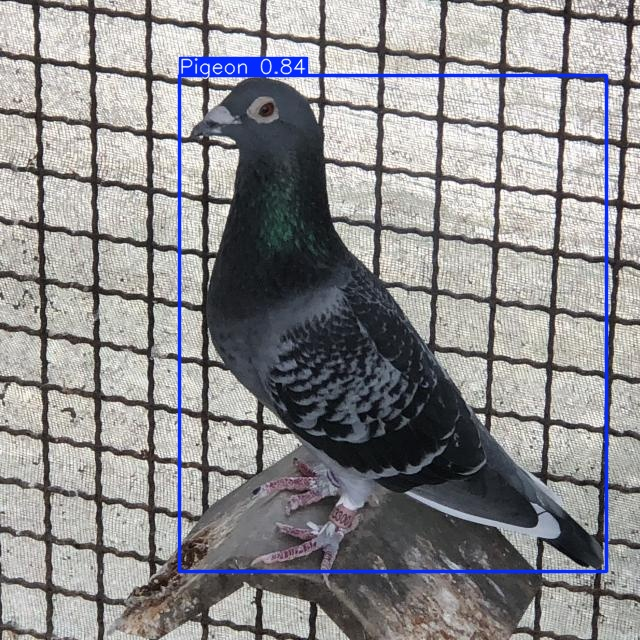

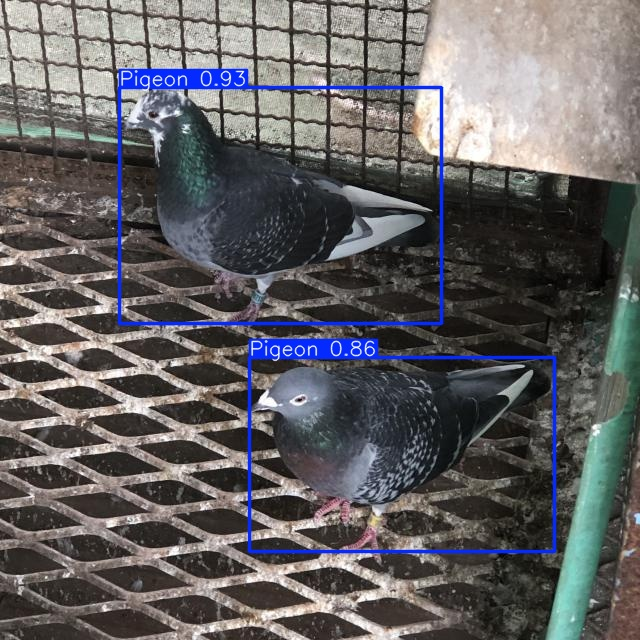

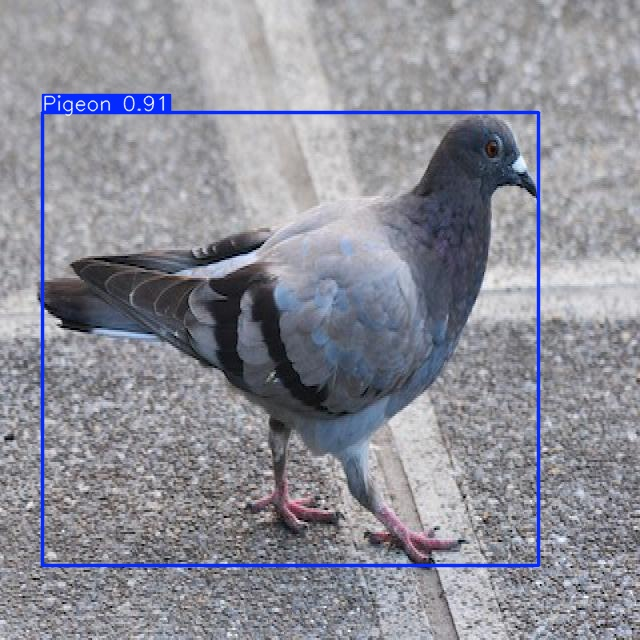

In [24]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

In [25]:
!cd {HOME}
%ls

datasets/  PXL_20210809_185425726-scaled.jpeg               webcam/
LiteRT/    runs/                                            yolo11n.pt
models/    Tensorflow_2_Object_Detection_Train_model.ipynb  yolo11s.pt


In [33]:
!pip install --upgrade ultralytics
!pip install --upgrade supervision

  Using cached ultralytics-8.3.64-py3-none-any.whl.metadata (35 kB)
Using cached ultralytics-8.3.64-py3-none-any.whl (910 kB)
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.3.40
    Uninstalling ultralytics-8.3.40:
      Successfully uninstalled ultralytics-8.3.40


In [32]:
import os
from ultralytics import YOLO

# Load the YOLO11 model
HOME = os.getcwd()

# Now you can use {HOME} in your model path
model_path = f"{HOME}/runs/detect/train/weights/best.pt"

# Load the YOLOv11 model using the updated path
model = YOLO(model_path)

# Export the model to TFLite format
model.export(format="tflite")  # creates 'yolo11n_float32.tflite'

# Load the exported TFLite model
#tflite_model = YOLO("best_float32.tflite")

# Run inference
#results = tflite_model("https://ultralytics.com/images/bus.jpg")

Ultralytics 8.3.40 🚀 Python-3.9.21 torch-2.5.1+cu124 CPU (AMD Ryzen 7 4800H with Radeon Graphics)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs

PyTorch: starting from '/home/toor/dev/tfoo/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (18.3 MB)

TensorFlow SavedModel: starting export with tensorflow 2.18.0...

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.47...
ONNX: export success ✅ 1.3s, saved as '/home/toor/dev/tfoo/runs/detect/train/weights/best.onnx' (36.2 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.20.0...


E0000 00:00:1737398011.762228    5602 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1737398011.802267    5602 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1737398011.819468    5602 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and 

ERROR: The trace log is below.
Traceback (most recent call last):
  File "/home/toor/miniconda3/envs/myenv/lib/python3.9/site-packages/onnx2tf/utils/common_functions.py", line 310, in print_wrapper_func
    result = func(*args, **kwargs)
  File "/home/toor/miniconda3/envs/myenv/lib/python3.9/site-packages/onnx2tf/utils/common_functions.py", line 383, in inverted_operation_enable_disable_wrapper_func
    result = func(*args, **kwargs)
  File "/home/toor/miniconda3/envs/myenv/lib/python3.9/site-packages/onnx2tf/utils/common_functions.py", line 53, in get_replacement_parameter_wrapper_func
    func(*args, **kwargs)
  File "/home/toor/miniconda3/envs/myenv/lib/python3.9/site-packages/onnx2tf/ops/Mul.py", line 211, in make_node
    correction_process_for_accuracy_errors(
  File "/home/toor/miniconda3/envs/myenv/lib/python3.9/site-packages/onnx2tf/utils/common_functions.py", line 5804, in correction_process_for_accuracy_errors
    min_abs_err_perm_1: int = [idx for idx in range(len(validatio

AttributeError: 'tuple' object has no attribute 'tb_frame'

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [ ]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

In [ ]:
!pip install inference

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.